In [1]:
import pandas as pd
import numpy as np

In [2]:
# Подгружаем необходимые библиотеки
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_classif, mutual_info_classif 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, fbeta_score, roc_curve

In [4]:
from datetime import datetime, date, time

Функции, используемые в блокноте:

In [5]:
# Функция обработки выборки
def data_preprocessing(data):
    data['education'].fillna('SCH', inplace=True)
    data['education_cat'] = data['education'].apply(education_cat)
    data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: x if x < 3 else 3)
    data['bki_request_cnt'] = data['bki_request_cnt'].apply(bki_request_cnt_cutback)
    col_dummies = ['education', 'sex', 'car', 'car_type', 'good_work', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'foreign_passport']
    data_dummies = pd.get_dummies(data[col_dummies], columns=col_dummies)
    data = pd.concat([data, data_dummies], axis = 1 )
    for col in ['car', 'car_type', 'foreign_passport']:
        data[col] =  data[col].apply(lambda x: 0 if x == 'N' else 1 )
    data['car_with_type'] = (data['car']+data['car_type'])/2
    data['age_log'] = data['age'].apply(lambda x: np.log(x))
    data['income_log'] = data['income'].apply(lambda x: np.log(x))
    data = data.drop(['client_id', 'app_date', 'education', 'sex', 'age', 'income'], axis = 1)
    
       
    return data
    

In [6]:
def education_cat(el):
    '''Обработка колонки education - перевод в числовые ранговые переменные'''
    if el == 'SCH':
        return 1
    elif el == 'GRD':
        return 2
    elif el == 'UGR':
        return 3
    elif el == 'PGR':
        return 4
    elif el == 'ACD':
        return 5

In [7]:
def feature_control(X_train, X_valid):
    '''Функция контроля количества признаков в выборках'''
    col_train = list(X_train.columns)
    col_valid = list(X_valid.columns)
    if col_train == col_valid:
        print('С колонками признаков Все ок!')
        return
    excess_col = []
    for i in range(len(col_train)-1):
        if i not in col_valid:
            excess_col.append(i)
    print('Излишние колонки в Обучаемой выборке:', excess_col)        
    excess_col = []
    for i in range(len(col_valid)-1):
        if i not in col_train:
            excess_col.append(i)
    print('Излишние колонки в Проверяемой выборке:', excess_col)  
   

In [8]:
def bki_request_cnt_cutback(x):
    "Сокращение значений колонки bki_request_cnt, с учетом сохраения динамики"
    if x < 7:
        return x
    elif x < 9:
        return 7
    else:
        return 8


In [9]:
def graph_bin_cat_col(col):
    """Построение графика колонки бинарного/категориального признака датафрейма"""
    print(f"График и таблица по колонке '{col}'")
    data.groupby([col])['default'].value_counts().plot(kind = 'bar')
    plt.show()
    df_group = data.groupby([col])['default'].value_counts(normalize = True)
    print(df_group)
    print()
    print('-----')

In [10]:
def model_training(col, hyper_options = ''):
    """Функция обучения модели и построения метрик"""
    if hyper_options == '':
        model = LogisticRegression()
    else:  
        model = LogisticRegression(**hyper_options)
    
    model.fit(X_train[col], y_train)
    y_pred = model.predict(X_valid[col])
    y_pred_proba = model.predict_proba(X_valid[col])
    y_pred_train = model.predict(X_train[col])
    # Считаем метрики
    print('Матрица ошибок обучаемой выборки')
    print(confusion_matrix(y_train, y_pred_train))
    print()
    print('Матрица ошибок валидационной выборки')
    print(confusion_matrix(y_valid, y_pred))
    print()
    roc_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
    print(f"roc_auc: {roc_auc}")
    # Построение графика 
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    print(f" Метрика f_beta на обучаемой выборке: {fbeta_score(y_train, y_pred_train, beta = 0.5)}")
    print(f" Метрика f_beta на валидационной выборке: {fbeta_score(y_valid, y_pred, beta = 0.5)}")
    
    return model
            
    

In [11]:
def Selection_of_hyperparameters(col):
    """Функция подбора оптимальных гиперпараметров"""
    
    
    model = LogisticRegression()
    gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
    gridsearch.fit(X_train[col], y_train)
    model_1 = gridsearch.best_estimator_

    ##печатаем параметры
    best_parameters = model_1.get_params()
    for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    return best_parameters


In [12]:
# Описания полей
#     client_id - идентификатор клиента
#     education - уровень образования
#     sex - пол заемщика
#     age - возраст заемщика
#     car - флаг наличия автомобиля
#     car_type - флаг автомобиля иномарки
#     decline_app_cnt - количество отказанных прошлых заявок
#     good_work - флаг наличия “хорошей” работы
#     bki_request_cnt - количество запросов в БКИ
#     home_address - категоризатор домашнего адреса
#     work_address - категоризатор рабочего адреса
#     income - доход заемщика
#     foreign_passport - наличие загранпаспорта
#     sna - связь заемщика с клиентами банка
#     first_time - давность наличия информации о заемщике
#     score_bki - скоринговый балл по данным из БКИ
#     region_rating - рейтинг региона
#     app_date - дата подачи заявки
#     default - флаг дефолта (невозврата) по кредиту

In [13]:
# Загружаем датасет и смотрим его
data = pd.read_csv('train.csv')
display(data.head())
data.info()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

<AxesSubplot:xlabel='education', ylabel='count'>

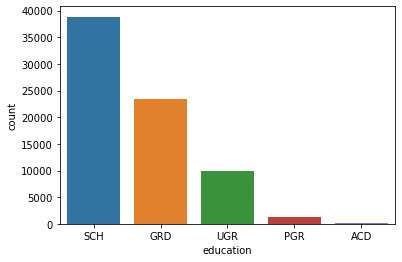

In [14]:
# Заполнение пропусков 'education'
# Посмотрим как этот столбец влияет на целевую переменную
sns.countplot(x = 'education', data = data)

<AxesSubplot:xlabel='education', ylabel='default'>

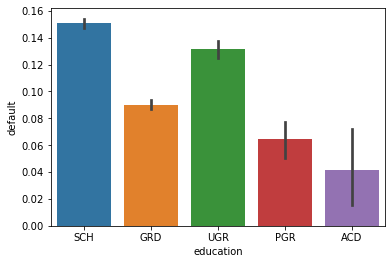

In [15]:
sns.barplot(x = 'education', y = 'default', data = data)

In [16]:
data_group = data.groupby(['education'])['default'].value_counts(normalize = True)
data_group
# Влияние данного признака на целевую переменную неравнозначно. 
# признак default чаще всего с образованием SCH (15%) и UGR (13%) 

education  default
ACD        0          0.958763
           1          0.041237
GRD        0          0.909908
           1          0.090092
PGR        0          0.935561
           1          0.064439
SCH        0          0.849408
           1          0.150592
UGR        0          0.868480
           1          0.131520
Name: default, dtype: float64

In [17]:
# Распределение пропусков признака 'education' относительно целевой переменной
data[data['education'].isna() == True]['default'].value_counts(normalize = True)

0    0.885993
1    0.114007
Name: default, dtype: float64

In [18]:
# Заполняем по моде:
data['education'].fillna('SCH', inplace=True)
# Проверка - корректно ли все прошло
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73799 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [19]:
# Преобразуем дату в столбце 'app_date' в формат даты
data['app_date'] = data['app_date'].apply(pd.to_datetime)

# Анализ данных

In [20]:
# Списки по типу признаков:
# переменная даты
date_col = ['app_date']

#бинарные переменные 
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']

#числовые переменные

num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

# Никак не влияющий на целевую переменную признак 
del_col = ['client_id']

In [21]:
# Посмотрим целевую переменную
data['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [22]:
data['default'].value_counts( normalize = True)
# Наблюдаем дисбаланс по данному признаку. Не критический, но надо будет учесть при обучении

0    0.873006
1    0.126994
Name: default, dtype: float64

In [23]:
# Посмотрим период
print(f"Период за который представлены данные: {data['app_date'].min()} - {data['app_date'].max()}")
# Совсем маленький - 4 месяца, сезонность не посмотришь.

Период за который представлены данные: 2014-01-01 00:00:00 - 2014-04-30 00:00:00


In [24]:
# Сформируем признак из даты - какой день недели
data['date_week'] = data['app_date'].apply(lambda d: d.weekday())

<AxesSubplot:xlabel='date_week', ylabel='count'>

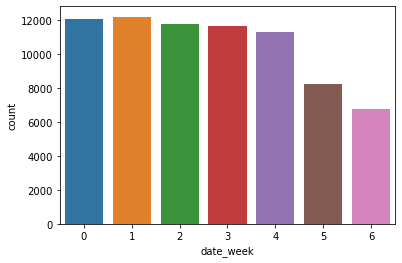

In [25]:
sns.countplot(x = 'date_week', data = data)

In [26]:
data_group = data.groupby(['date_week'])['default'].value_counts(normalize = True)
data_group
# Этот признак не оказывает влияние на целевую переменную.
# Во все дни недели примерно одинаковый процент признака default. 
# Не включаем в функцию обработки датафрейма

date_week  default
0          0          0.872921
           1          0.127079
1          0          0.872618
           1          0.127382
2          0          0.875724
           1          0.124276
3          0          0.868015
           1          0.131985
4          0          0.880050
           1          0.119950
5          0          0.869032
           1          0.130968
6          0          0.870815
           1          0.129185
Name: default, dtype: float64

Рассмотрим колличественные признаки

<AxesSubplot:xlabel='age', ylabel='Count'>

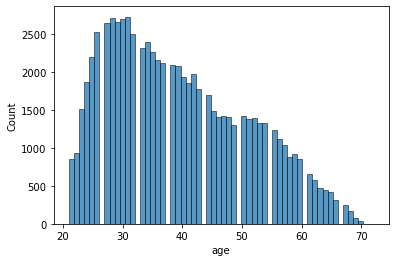

In [27]:
# Возраст. Гистограмма смещена в лево. Чаще всего за кредитами обращаются в возрасте +-30
sns.histplot(data.age)

<AxesSubplot:xlabel='age_log', ylabel='Count'>

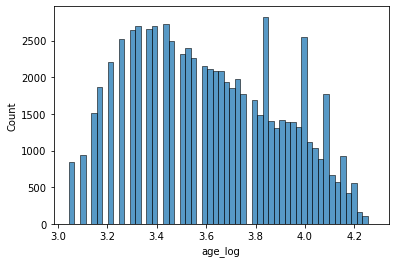

In [28]:
# Попробуем логарифмировать признак - получится ли превратить его в нормальное распределение?
data['age_log'] = data['age'].apply(lambda x: np.log(x))
sns.histplot(data.age_log)
# Конечно не супер получилось. Но посмотрим какой будет лучше работать.

<AxesSubplot:xlabel='decline_app_cnt', ylabel='Count'>

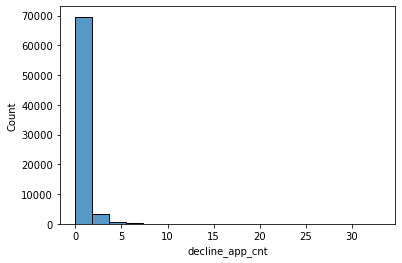

In [29]:
# Признак "количество отказанных прошлых заявок"
sns.histplot(data.decline_app_cnt)

In [30]:
data['decline_app_cnt'].value_counts(normalize = True)
# В основном заявки удовлетворяются с первой попытки (83%), 1 отказ получают 11% человек, 
# 2 отказа - уже только 3%, а дальше и того меньше. 

0     0.829469
1     0.113782
2     0.033442
3     0.012236
4     0.005610
5     0.002236
6     0.001531
7     0.000650
9     0.000325
8     0.000257
10    0.000149
11    0.000122
13    0.000041
12    0.000027
14    0.000027
16    0.000027
15    0.000014
19    0.000014
22    0.000014
24    0.000014
33    0.000014
Name: decline_app_cnt, dtype: float64

In [31]:
# Скорректируем этот признак - всех у кого больше трех отказов прировняем к 3
data['decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: x if x < 3 else 3)

In [32]:
data['decline_app_cnt'].value_counts(normalize = True)

0    0.829469
1    0.113782
2    0.033442
3    0.023307
Name: decline_app_cnt, dtype: float64

<AxesSubplot:xlabel='decline_app_cnt', ylabel='Count'>

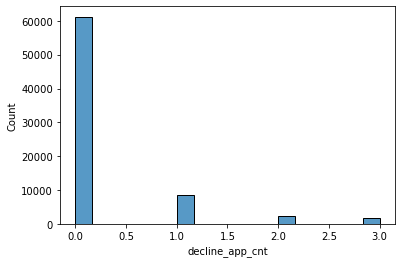

In [33]:
sns.histplot(data.decline_app_cnt)

<AxesSubplot:xlabel='bki_request_cnt', ylabel='Count'>

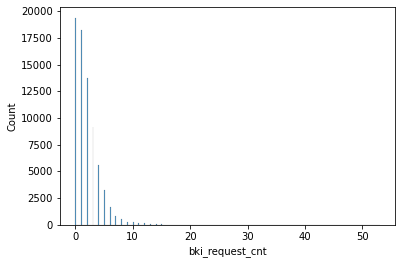

In [34]:
# Признак "количество запросов в БКИ"
sns.histplot(data.bki_request_cnt)

In [35]:
data['bki_request_cnt'].value_counts()
# график получился как половина нормального распределения (количество запросов снижается от 0 до 4 ощутимо, 
# далее более сглажено) 
# Проделаем тоже, что и с признаком decline_app_cnt - сократим хвост. 

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
22        4
28        4
25        2
26        2
27        2
32        2
41        1
46        1
45        1
29        1
36        1
34        1
33        1
53        1
Name: bki_request_cnt, dtype: int64

In [36]:
data_group_bki_request_cnt = data.groupby(['bki_request_cnt'])['default'].value_counts(normalize = True)
data_group_bki_request_cnt[0:30]
# Видим, что чем больше запросов, тем выше процент default
# После 7 уже закономерность начинает прыгать. Напишем функцию обработкиэтого признака

bki_request_cnt  default
0                0          0.905010
                 1          0.094990
1                0          0.881210
                 1          0.118790
2                0          0.867627
                 1          0.132373
3                0          0.854359
                 1          0.145641
4                0          0.848765
                 1          0.151235
5                0          0.830477
                 1          0.169523
6                0          0.836268
                 1          0.163732
7                0          0.842723
                 1          0.157277
8                0          0.807087
                 1          0.192913
9                0          0.806020
                 1          0.193980
10               0          0.822222
                 1          0.177778
11               0          0.755319
                 1          0.244681
12               0          0.743056
                 1          0.256944
13           

In [37]:
data['bki_request_cnt'] = data['bki_request_cnt'].apply(bki_request_cnt_cutback)
data['bki_request_cnt'].value_counts()

0    19381
1    18276
2    13749
3     9187
4     5627
5     3268
6     1704
7     1360
8     1247
Name: bki_request_cnt, dtype: int64

<AxesSubplot:xlabel='bki_request_cnt', ylabel='Count'>

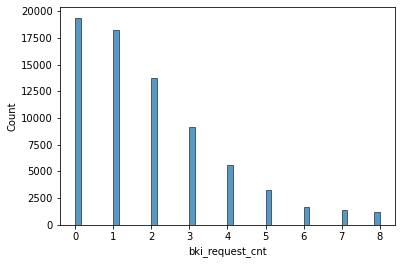

In [38]:
sns.histplot(data.bki_request_cnt)
# Стало лучше. Попробуем логарифмировать


In [39]:
# data['bki_request_cnt_log'] = data['bki_request_cnt'].apply(lambda x: np.log(x+1))
# sns.histplot(data.bki_request_cnt_log)
# Стало хуже распределение - не берем

Минимальнй доход: 1000
Максимальный доход: 1000000


<AxesSubplot:xlabel='income', ylabel='Count'>

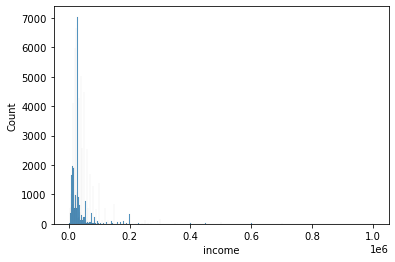

In [40]:
# Признак "доход заемщика"
print(f"Минимальнй доход: {data.income.min()}")
print(f"Максимальный доход: {data.income.max()}")
sns.histplot(data.income)
# Большой разброс между доходами людей

In [41]:
data['income'].describe()
# средняя и медиана не совпадают, очень большое стандартное отклонение - есть некоторые люди с очень большим доходом
# Большенство же имеет доход от 20 до 48 тысяч. 

count      73799.000000
mean       41099.775417
std        46166.322400
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

<AxesSubplot:xlabel='income_log', ylabel='Count'>

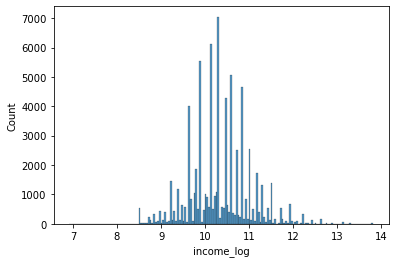

In [42]:
# Логарифмируем данный признак
data['income_log'] = data['income'].apply(lambda x: np.log(x))
sns.histplot(data.income_log)
# Стало гораздо получше

<AxesSubplot:xlabel='score_bki', ylabel='Count'>

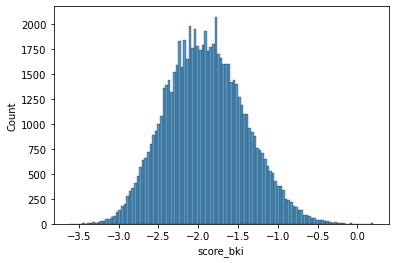

In [43]:
# Признак скоринговый балл по данным из БКИ
sns.histplot(data.score_bki)
# Имеет нормальное распределение

<AxesSubplot:xlabel='score_bki', ylabel='default'>

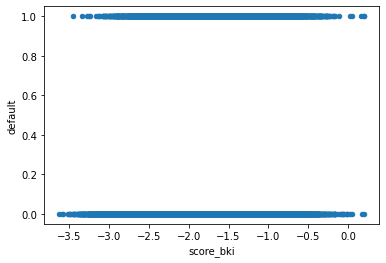

In [44]:
data.plot(x = 'score_bki', y = 'default', kind = 'scatter')
# По графику зависимость не видна, хотя предполагала, что должна быть. 
# Дальше будем строить матрицу корреляции

Посмотрим категориальные и бинарнын признаки

График и таблица по колонке 'sex'


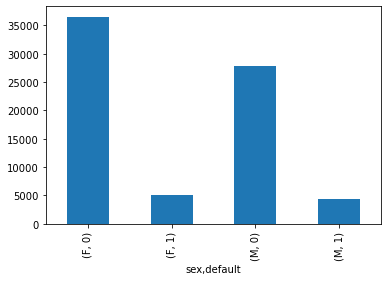

sex  default
F    0          0.878759
     1          0.121241
M    0          0.865589
     1          0.134411
Name: default, dtype: float64

-----


In [45]:
graph_bin_cat_col('sex')
# По пропорциям мужчины невозвращают на 1,3% чаще

График и таблица по колонке 'car'


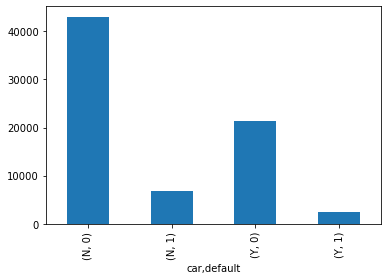

car  default
N    0          0.863040
     1          0.136960
Y    0          0.893729
     1          0.106271
Name: default, dtype: float64

-----
График и таблица по колонке 'car_type'


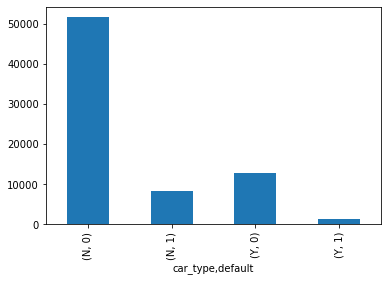

car_type  default
N         0          0.863742
          1          0.136258
Y         0          0.912550
          1          0.087450
Name: default, dtype: float64

-----
График и таблица по колонке 'good_work'


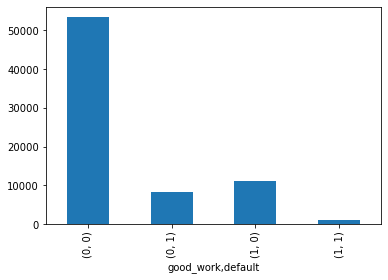

good_work  default
0          0          0.866591
           1          0.133409
1          0          0.905498
           1          0.094502
Name: default, dtype: float64

-----
График и таблица по колонке 'foreign_passport'


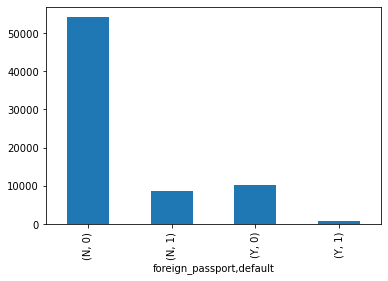

foreign_passport  default
N                 0          0.863676
                  1          0.136324
Y                 0          0.925899
                  1          0.074101
Name: default, dtype: float64

-----


In [46]:
for col in ['car', 'car_type', 'good_work', 'foreign_passport']:
    graph_bin_cat_col(col)
    
# наличие машины и тем более иномарки, хорошей работы и загран паспорта снижает процент default   

График и таблица по колонке 'education'


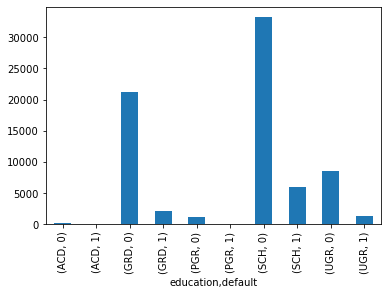

education  default
ACD        0          0.958763
           1          0.041237
GRD        0          0.909908
           1          0.090092
PGR        0          0.935561
           1          0.064439
SCH        0          0.849695
           1          0.150305
UGR        0          0.868480
           1          0.131520
Name: default, dtype: float64

-----
График и таблица по колонке 'work_address'


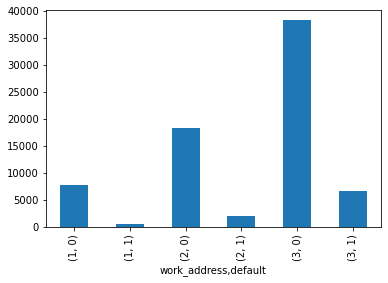

work_address  default
1             0          0.925846
              1          0.074154
2             0          0.897493
              1          0.102507
3             0          0.852043
              1          0.147957
Name: default, dtype: float64

-----
График и таблица по колонке 'home_address'


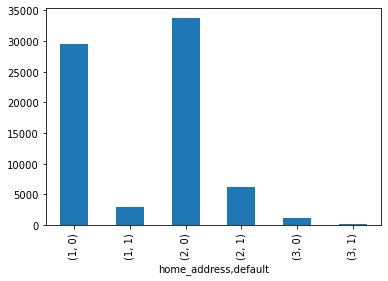

home_address  default
1             0          0.907104
              1          0.092896
2             0          0.844854
              1          0.155146
3             0          0.883943
              1          0.116057
Name: default, dtype: float64

-----
График и таблица по колонке 'sna'


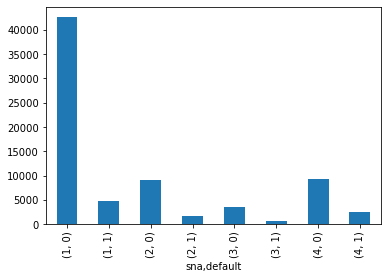

sna  default
1    0          0.901799
     1          0.098201
2    0          0.850179
     1          0.149821
3    0          0.842348
     1          0.157652
4    0          0.788493
     1          0.211507
Name: default, dtype: float64

-----
График и таблица по колонке 'first_time'


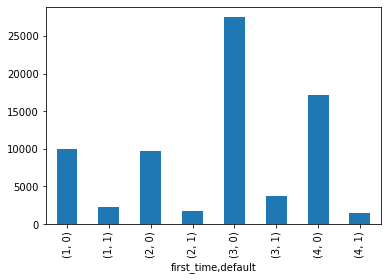

first_time  default
1           0          0.813874
            1          0.186126
2           0          0.844571
            1          0.155429
3           0          0.879731
            1          0.120269
4           0          0.917970
            1          0.082030
Name: default, dtype: float64

-----
График и таблица по колонке 'region_rating'


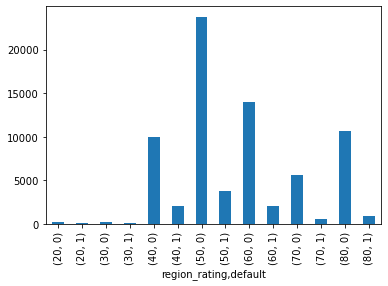

region_rating  default
20             0          0.786408
               1          0.213592
30             0          0.810000
               1          0.190000
40             0          0.830298
               1          0.169702
50             0          0.863859
               1          0.136141
60             0          0.871166
               1          0.128834
70             0          0.907566
               1          0.092434
80             0          0.926846
               1          0.073154
Name: default, dtype: float64

-----


In [47]:
for col in ['education', 'work_address', 'home_address', 'sna', 'first_time', 'region_rating']:
    graph_bin_cat_col(col)
    
# Все признаки имеют зависимость с целевой переменной. И она в основном линейная 
# С увеличением/уменьшением процент невозврата либо растет, либо падает

In [48]:
# На основании проведенного анализа создадим функции обработки датафрейма
# Разместим ее в самом начале

In [49]:
# Загрузим по новой и разделим датасет, проведем обработку
df = pd.read_csv('train.csv')
train, valid =  train_test_split(df, test_size = 0.3, random_state=42)

In [50]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
24313,78714,26MAR2014,SCH,M,22,Y,Y,0,0,-1.477455,0,50,2,3,20000,4,1,N,0
35263,58698,07MAR2014,SCH,F,47,Y,N,3,0,-1.683615,4,40,2,3,25000,4,4,N,1
15277,88447,04APR2014,SCH,M,24,N,N,1,0,-3.004253,3,40,2,3,21000,1,3,N,0
64628,100305,17APR2014,GRD,M,26,N,N,0,0,-2.173402,1,70,1,2,30000,1,3,N,0
69368,61611,11MAR2014,SCH,F,30,Y,N,4,1,-1.269670,1,50,2,3,35000,1,3,N,1


In [51]:
train['default'].value_counts(normalize = True)
# Пропорции целевой переменной разбились в соотношеннии аналогичном всему датафрейму

0    0.872394
1    0.127606
Name: default, dtype: float64

In [52]:
train = data_preprocessing(train)
train.head()

D:\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-5-683c06a76f39>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education_cat'] = data['education'].apply(education_cat)
<ipython-input-5-683c06a76f39>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,sna,...,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,foreign_passport_N,foreign_passport_Y,car_with_type,age_log,income_log
24313,1,1,0,0,-1.477455,0,50,2,3,4,...,1,1,0,0,0,1,0,1.0,3.091042,9.903488
35263,1,0,3,0,-1.683615,4,40,2,3,4,...,1,0,0,0,1,1,0,0.5,3.850148,10.126631
15277,0,0,1,0,-3.004253,3,40,2,3,1,...,0,0,0,1,0,1,0,0.0,3.178054,9.952278
64628,0,0,0,0,-2.173402,1,70,1,2,1,...,0,0,0,1,0,1,0,0.0,3.258097,10.308953
69368,1,0,3,1,-1.269670,1,50,2,3,1,...,0,0,0,1,0,1,0,0.5,3.401197,10.463103


In [53]:
# Нормализация признаков тренировочной выборки
scaler_min_max = MinMaxScaler()
col_min_max = ['decline_app_cnt', 'good_work', 'bki_request_cnt', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
train[col_min_max] = scaler_min_max.fit_transform(train[col_min_max])
col_standard = ['age_log', 'decline_app_cnt', 'bki_request_cnt', 'income_log','score_bki']
scaler_standard = StandardScaler()
#train[col_standard] = scaler_standard.fit_transform(train[col_standard])
scaler_robust = RobustScaler() # использует медины и квантили попробовать вместо StandardScaler
train[col_standard] = scaler_robust.fit_transform(train[col_standard])

In [54]:
train.head()

,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,sna,...,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,foreign_passport_N,foreign_passport_Y,car_with_type,age_log,income_log
24313,1,1,0.000000,0.0,0.643373,-0.333333,0.500000,0.5,1.0,1.0,...,1,1,0,0,0,1,0,1.0,-1.106109,-0.463141
35263,1,0,1.000000,0.0,0.344213,1.000000,0.333333,0.5,1.0,1.0,...,1,0,0,0,1,1,0,0.5,0.508995,-0.208256
15277,0,0,0.333333,0.0,-1.572169,0.666667,0.333333,0.5,1.0,0.0,...,0,0,0,1,0,1,0,0.0,-0.920980,-0.407410
64628,0,0,0.000000,0.0,-0.366519,0.000000,0.833333,0.0,0.5,0.0,...,0,0,0,1,0,1,0,0.0,-0.750678,0.000000
69368,1,0,1.000000,1.0,0.944891,0.000000,0.500000,0.5,1.0,0.0,...,0,0,0,1,0,1,0,0.5,-0.446210,0.176078


In [55]:
matr_corr = train.corr()
matr_corr

,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,sna,...,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,foreign_passport_N,foreign_passport_Y,car_with_type,age_log,income_log
car,1.000000,0.698024,-0.040849,0.003841,-0.046541,-0.038199,0.060291,-0.024055,-0.005140,-0.074215,...,-0.065502,-0.077749,-0.020730,0.022812,0.057713,-0.106379,0.106379,0.935277,-0.036677,0.322542
car_type,0.698024,1.000000,-0.053098,0.017703,-0.041456,-0.004409,0.101628,-0.011934,0.003201,-0.087573,...,-0.076607,-0.089197,-0.024674,0.022125,0.071546,-0.146298,0.146298,0.906277,-0.033134,0.365360
decline_app_cnt,-0.040849,-0.053098,1.000000,-0.027829,0.204619,0.142312,-0.041302,0.011620,0.016284,0.070513,...,0.048189,0.040024,0.043046,-0.005139,-0.064123,0.027822,-0.027822,-0.050356,-0.126091,-0.013939
good_work,0.003841,0.017703,-0.027829,1.000000,0.003114,0.007974,0.073915,-0.001016,-0.006827,-0.050343,...,-0.038158,-0.042767,-0.015791,0.011613,0.036456,-0.043196,0.043196,0.011017,-0.073992,0.054970
score_bki,-0.046541,-0.041456,0.204619,0.003114,1.000000,0.150922,0.010203,0.013656,0.009943,0.065902,...,0.043598,0.024270,0.046397,0.014483,-0.075735,0.024347,-0.024347,-0.047961,-0.106637,0.002169
bki_request_cnt,-0.038199,-0.004409,0.142312,0.007974,0.150922,1.000000,0.004057,0.006246,0.002191,0.002686,...,0.003974,-0.016366,-0.008076,0.012649,0.006328,-0.003755,0.003755,-0.024727,0.056543,0.095802
region_rating,0.060291,0.101628,-0.041302,0.073915,0.010203,0.004057,1.000000,0.233725,0.252394,-0.076409,...,-0.057731,-0.059400,-0.003761,-0.039949,0.099183,-0.253485,0.253485,0.085818,-0.091507,0.312394
home_address,-0.024055,-0.011934,0.011620,-0.001016,0.013656,0.006246,0.233725,1.000000,0.729226,0.115466,...,0.132326,0.089393,-0.018280,-0.054127,0.000325,-0.037365,0.037365,-0.020098,-0.003228,0.046074
work_address,-0.005140,0.003201,0.016284,-0.006827,0.009943,0.002191,0.252394,0.729226,1.000000,0.109834,...,0.124632,0.088513,-0.009381,-0.052839,-0.007784,-0.040527,0.040527,-0.001452,-0.017908,0.068871
sna,-0.074215,-0.087573,0.070513,-0.050343,0.065902,0.002686,-0.076409,0.115466,0.109834,1.000000,...,0.878003,0.519422,0.049761,-0.172146,-0.289387,0.175474,-0.175474,-0.087091,-0.068436,-0.122679


<AxesSubplot:>

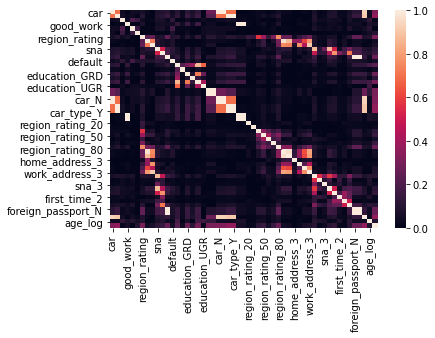

In [56]:
sns.heatmap(train.corr().abs(), vmin=0, vmax=1)
# Между некоторыми признаками есть сильная корреляция

In [57]:
# Посмотрим какие признаки сильно скоррелированы, чтоб потом учесть

for col in matr_corr.columns:
    print(matr_corr.abs().sort_values((col), ascending = False)[[col]][:5])

                    car
car_N          1.000000
car            1.000000
car_Y          1.000000
car_with_type  0.935277
car_type       0.698024
               car_type
car_type       1.000000
car_type_Y     1.000000
car_type_N     1.000000
car_with_type  0.906277
car_Y          0.698024
                 decline_app_cnt
decline_app_cnt         1.000000
score_bki               0.204619
bki_request_cnt         0.142312
age_log                 0.126091
default                 0.124434
               good_work
good_work_1     1.000000
good_work       1.000000
good_work_0     1.000000
education_SCH   0.165324
education_GRD   0.153320
                 score_bki
score_bki         1.000000
decline_app_cnt   0.204619
default           0.173871
bki_request_cnt   0.150922
age_log           0.106637
                 bki_request_cnt
bki_request_cnt         1.000000
score_bki               0.150922
decline_app_cnt         0.142312
income_log              0.095802
default                 0.079378
    

In [58]:
# Сформируем списки столбцов для обучения - 2 варианта
var_1 = ['age_log', 'car_with_type', 'decline_app_cnt', 'good_work', 'score_bki',
       'bki_request_cnt', 'region_rating', 'home_address', 'work_address',
       'income_log', 'sna', 'first_time', 'foreign_passport', 'sex_F', 'sex_M', 'education_cat']
var_2 = ['age_log', 'income_log', 'education_ACD', 'education_GRD', 'education_PGR',
       'education_SCH', 'education_UGR', 'sex_F', 'sex_M', 'car_N', 'car_Y',
       'car_type_N', 'car_type_Y', 'good_work_0', 'good_work_1',
       'region_rating_20', 'region_rating_30', 'region_rating_40',
       'region_rating_50', 'region_rating_60', 'region_rating_70',
       'region_rating_80', 'home_address_1', 'home_address_2',
       'home_address_3', 'work_address_1', 'work_address_2', 'work_address_3',
       'sna_1', 'sna_2', 'sna_3', 'sna_4', 'first_time_1', 'first_time_2',
       'first_time_3', 'first_time_4', 'foreign_passport_N',
       'foreign_passport_Y' ]


In [59]:
matr_corr.abs().sort_values(['default'], ascending = False)[['default']]
# Далее, исходя из корреляции, потестируем сколько колонок взять для списка на обучение

,default
default,1.000000
score_bki,0.173871
sna,0.124487
decline_app_cnt,0.124434
sna_1,0.116030
sna_4,0.107570
first_time,0.104114
region_rating,0.090259
home_address_2,0.085232
home_address_1,0.084945


In [60]:
valid = data_preprocessing(valid).copy()
# Нормализация признаков валидационной выборки
valid[col_min_max] = scaler_min_max.fit_transform(valid[col_min_max])
valid[col_standard] = scaler_robust.fit_transform(valid[col_standard])
valid.head()

D:\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
<ipython-input-5-683c06a76f39>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['education_cat'] = data['education'].apply(education_cat)
<ipython-input-5-683c06a76f39>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,sna,...,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,foreign_passport_N,foreign_passport_Y,car_with_type,age_log,income_log
68068,0,0,0.333333,0.0,1.053347,0.666667,0.333333,0.0,0.5,0.0,...,0,0,0,0,1,1,0,0.0,-0.518341,-0.310977
60795,0,0,0.000000,0.0,0.879286,0.333333,0.500000,0.0,0.5,0.0,...,0,0,0,0,1,1,0,0.0,0.956429,-0.811253
5365,0,0,0.000000,0.0,0.161463,-0.333333,1.000000,0.5,1.0,1.0,...,1,1,0,0,0,1,0,0.0,1.325923,-0.285806
27565,1,1,0.000000,0.0,1.224565,-0.333333,0.500000,0.5,1.0,1.0,...,1,0,0,1,0,1,0,1.0,-0.670380,0.904934
72235,0,0,0.333333,0.0,0.588987,1.666667,0.500000,0.5,1.0,0.0,...,0,0,0,0,1,1,0,0.0,-0.308896,-0.213388


In [61]:
X_train = train.drop(['default'] , axis = 1)
y_train = train['default']
X_valid = valid.drop(['default'], axis = 1)
y_valid = valid['default']

In [62]:
feature_control(X_train, X_valid)

С колонками признаков Все ок!


# Обучение

1. Вариант со списком для обучения, сформированным автоматически по максимальной корреляции с целевой переменной

In [63]:
# Подбор количесва столбцов для списка обучения
roc_auc_ = 0
f_beta_t_ = 0
f_beta_v_ = 0
i_roc_auc_ = 0
i_beta_t_ = 0
i_beta_v_ = 0
roc_auc_l = []
f_beta_t_l = []
f_beta_v_l = []


for i in range(matr_corr.shape[1]-5):
    col = matr_corr.abs().sort_values(['default'], ascending = False)[['default']].index[1:i+4]
    model = LogisticRegression()
    model.fit(X_train[col], y_train)
    y_pred = model.predict(X_valid[col])
    y_pred_proba = model.predict_proba(X_valid[col])
    y_pred_train = model.predict(X_train[col])
    # Считаем метрики
    roc_auc = roc_auc_score(y_valid, y_pred_proba[:,1])
    roc_auc_l.append(round(roc_auc, 3))
    f_beta_t = fbeta_score(y_train, y_pred_train, beta = 0.5)
    f_beta_t_l.append(round(f_beta_t, 3))
    f_beta_v = fbeta_score(y_valid, y_pred, beta = 0.5)
    f_beta_v_l.append(round(f_beta_v, 3))
    if roc_auc_ < roc_auc:
        roc_auc_ = roc_auc
        i_roc_auc_ = i+4
    if f_beta_t_ < f_beta_t:
        f_beta_t_ = f_beta_t
        i_beta_t_ = i+4
    if f_beta_v_ < f_beta_v:
        f_beta_v_ = f_beta_v
        i_beta_v_ = i+4
    


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

In [64]:
print(f"Максимальный roc_auc {roc_auc_} c количеством столбцов до {i_roc_auc_}")
print(f"Максимальный f_beta_t {f_beta_t_} c количеством столбцов до {i_beta_t_}")
print(f"Максимальный f_beta_v {f_beta_v_} c количеством столбцов до {i_beta_v_}")


Максимальный roc_auc 0.7354535978655092 c количеством столбцов до 45
Максимальный f_beta_t 0.11728395061728396 c количеством столбцов до 34
Максимальный f_beta_v 0.095926800472255 c количеством столбцов до 45


График изменения метрики roc_auc 


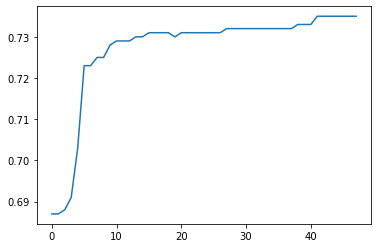

In [65]:
# Графики изменения метрик в зависимости от количества столбцов для обучения (x+4)
print("График изменения метрики roc_auc ")
plt.plot(roc_auc_l)

График изменения метрик f_beta для обучаемой и валидационной выборок
Синий - f_beta обучаемой и Оранжевый - f_beta валидационной


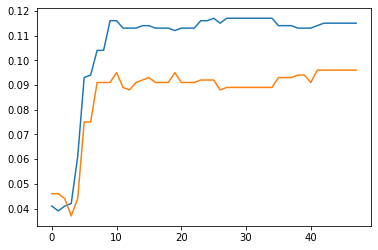

In [66]:
print("График изменения метрик f_beta для обучаемой и валидационной выборок")
print("Синий - f_beta обучаемой и Оранжевый - f_beta валидационной")
plt.plot(f_beta_t_l)
plt.plot(f_beta_v_l)

In [67]:
# Еще список для обучения, сформированный автоматически по максимальной корреляции с целевой переменной
col_for_predicted = matr_corr.abs().sort_values(['default'], ascending = False)[['default']].index[1:i_beta_v_]
col_for_predicted

Index(['score_bki', 'sna', 'decline_app_cnt', 'sna_1', 'sna_4', 'first_time',
       'region_rating', 'home_address_2', 'home_address_1', 'bki_request_cnt',
       'home_address', 'education_SCH', 'work_address', 'first_time_1',
       'first_time_4', 'education_GRD', 'work_address_3', 'region_rating_80',
       'foreign_passport', 'foreign_passport_Y', 'foreign_passport_N',
       'education_cat', 'car_type_N', 'car_type', 'car_type_Y', 'income_log',
       'work_address_1', 'region_rating_40', 'car_with_type', 'good_work_0',
       'good_work_1', 'good_work', 'work_address_2', 'car_N', 'car', 'car_Y',
       'first_time_2', 'region_rating_70', 'sna_2', 'education_PGR', 'age_log',
       'sna_3', 'region_rating_50', 'sex_M'],
      dtype='object')

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Матрица ошибок обучаемой выборки
[[44885   182]
 [ 6408   184]]

Матрица ошибок валидационной выборки
[[19273    87]
 [ 2715    65]]

roc_auc: 0.7354535978655092


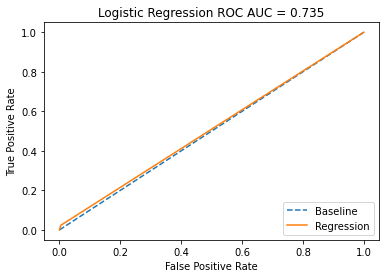

 Метрика f_beta на обучаемой выборке: 0.11420059582919562
 Метрика f_beta на валидационной выборке: 0.095926800472255


LogisticRegression()

In [68]:
model_training(col_for_predicted)

2. Вариант обучения со списком для обучения var_1

Матрица ошибок обучаемой выборки
[[44887   180]
 [ 6417   175]]

Матрица ошибок валидационной выборки
[[19272    88]
 [ 2722    58]]

roc_auc: 0.7300440721802723


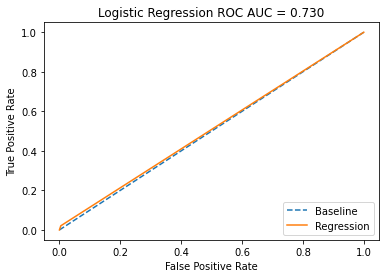

 Метрика f_beta на обучаемой выборке: 0.10921118322516225
 Метрика f_beta на валидационной выборке: 0.08620689655172414


LogisticRegression()

In [69]:
model_training(var_1)

3. Вариант обучения со списком для обучения var_2

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Матрица ошибок обучаемой выборки
[[45067     0]
 [ 6592     0]]

Матрица ошибок валидационной выборки
[[19360     0]
 [ 2780     0]]

roc_auc: 0.6802068066621083


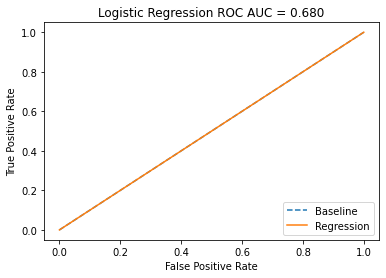

 Метрика f_beta на обучаемой выборке: 0.0
 Метрика f_beta на валидационной выборке: 0.0


LogisticRegression()

In [70]:
model_training(var_2)

Подбор оптимальных гиперпараметров

In [71]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol 1e-3
# чтобы получить оптимальные параметры модели в первом приближении

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]



In [72]:
hyper_1 = Selection_of_hyperparameters(col_for_predicted)

D:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.3364435         nan
 0.33641859        nan 0.05305157 0.05275676        nan 0.05333393
 0.05305157 0.05305157 0.05275676        nan 0.05305157 0.05305157
 0.33658439 0.33655391 0.33658439 0.33661349 0.33659783 0.33658439
 0.33655391 0.33658439 0.33666892 0.33659783 0.05304225 0.0524655
 0.05304225 0.05304225 0.05304225 0.0524655  0.05304225 0.05304225
 0.33668535 0.33685908 0.33665853 0.33668535 0.33668535 0.33685908
 0.33572875 0.33669826]
  warnings.warn(


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'lbfgs'
	tol: 0.001
	verbose: 0
	warm_start: False


D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [73]:
hyper_2 = Selection_of_hyperparameters(var_1)

D:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.33533737        nan
 0.33533695        nan 0.04885932 0.0494253         nan 0.04885932
 0.04885932 0.04885932 0.0494253         nan 0.04885932 0.04885932
 0.33535998 0.33533437 0.33537278 0.33535969 0.33534668 0.33535998
 0.33533437 0.33537278 0.3353307  0.33534668 0.04995818 0.05024052
 0.05024052 0.05024052 0.04995818 0.05024052 0.04967017 0.04995818
 0.33541608 0.33538956 0.33548079 0.33544915 0.33541608 0.33538956
 0.3354252  0.33533694]
  warnings.warn(


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


In [74]:
hyper_3 = Selection_of_hyperparameters(var_2)

D:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.29701295        nan
 0.29701264        nan 0.         0.                nan 0.
 0.         0.         0.                nan 0.         0.
 0.29690299 0.29693111 0.29689226 0.29676239 0.29700155 0.29690299
 0.29693111 0.29689226 0.29733903 0.29706826 0.         0.
 0.         0.         0.         0.         0.         0.
 0.2968405  0.2971902  0.29617321 0.29686359 0.2968405  0.2971902
 0.29519989 0.2969386 ]
  warnings.warn(


	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'ovr'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


D:\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Обучим модели с применением гипер паметров и посмотрим метрики

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Матрица ошибок обучаемой выборки
[[29965 15102]
 [ 2190  4402]]

Матрица ошибок валидационной выборки
[[12825  6535]
 [  891  1889]]

roc_auc: 0.7353371744752957


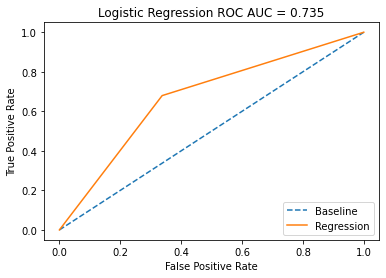

 Метрика f_beta на обучаемой выборке: 0.2601408850226929
 Метрика f_beta на валидационной выборке: 0.25893738348503126


In [75]:
model_1 = model_training(col_for_predicted, hyper_1)

Матрица ошибок обучаемой выборки
[[30009 15058]
 [ 2235  4357]]

Матрица ошибок валидационной выборки
[[12900  6460]
 [  903  1877]]

roc_auc: 0.7301176496819074


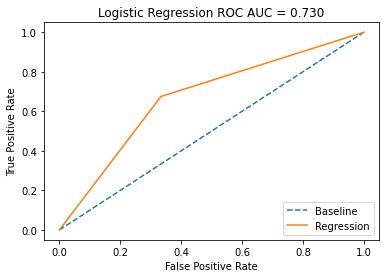

 Метрика f_beta на обучаемой выборке: 0.2585695295067179
 Метрика f_beta на валидационной выборке: 0.25977081488042514


In [76]:
model_2 = model_training(var_1, hyper_2)

Матрица ошибок обучаемой выборки
[[27761 17306]
 [ 2405  4187]]

Матрица ошибок валидационной выборки
[[11889  7471]
 [  994  1786]]

roc_auc: 0.6797884739728878


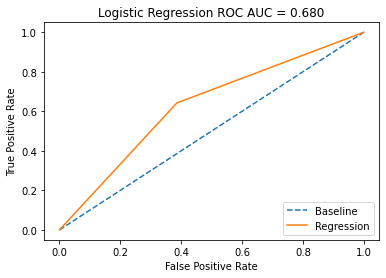

 Метрика f_beta на обучаемой выборке: 0.2261678406291863
 Метрика f_beta на валидационной выборке: 0.22432676848874594


In [77]:
model_3 = model_training(var_2, hyper_3)

Гипер параметры значительно улучшили метрику f_beta на обучаемой и валидационной выборках. Но при этом ROC_AUC осталась прежней.
По матрице ошибок видно, что модель стала больше выдавать ложноположительные и меньше ложноотрицательные. Т.е. она чаще стала сводиться к тому, что данный человек не вернет деньги, чем вернет. Для банка это как разница недополучть проценты или потерять сумму невозращенной части кредита. 

Займемся предсказанием для тестовой выборки и сформируем файл для кеггл

In [78]:
X_test = pd.read_csv('test.csv')
X_test = data_preprocessing(X_test)
# Нормализация признаков валидационной выборки
X_test[col_min_max] = scaler_min_max.fit_transform(X_test[col_min_max])
X_test[col_standard] = scaler_robust.fit_transform(X_test[col_standard])
feature_control(X_train, X_test)


С колонками признаков Все ок!


In [79]:
# Испробуем 2 модели 1 и 2 (они примерно одинаковый дают результат), третья модель показавыет худший результат. 
# Её даже не рассматриваем.

In [80]:
# По итогу первая модель показала лучший результат. Её оставляем как основную.
y_submit = model_1.predict(X_test[col_for_predicted])

In [81]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['default'] = y_submit
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


<AxesSubplot:ylabel='count'>

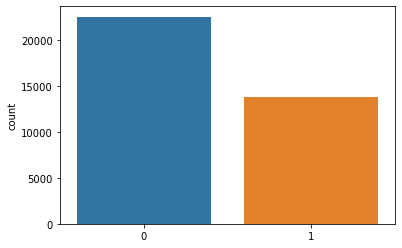

In [82]:
sns.countplot(x = y_submit)

In [83]:
y_submit.sum()

13818

In [84]:
len(y_submit)

36349

In [85]:
# Почему используется f_classif, а не f_regression? Можно пример в каком случае какой применять?
# Несколькими слайдами ранее было про то, что регрессия лучше классификации из-за значения вероятности дефолта.
# ---
# f_classif применяется при задаче классификации (например, бинарной, как в нашем случае), 
# а f_regression — для регрессии (когда целевая переменная может принимать бесконечность значений).